In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
import os
import PIL
import PIL.Image
import sys
import glob
from pathlib import Path


# Get the path of the dataset
os.chdir(sys.path[0])
working_directory = os.getcwd()
print(working_directory)
data_path = Path(working_directory + r"/dataset/IMG_CLASSES")

# Count the number of images within the  dataset
image_count = len(list(data_path.glob('*/*.jpg')))
print("The number of images in the dataset is " + str(image_count))

# Batch size and dimensions
batch_size = 30
IMG_SIZE = (200,200)

#Assigning the data splits and seed
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=IMG_SIZE,
    batch_size=batch_size
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=batch_size
)

c:\Users\Uzair\Desktop\CS Notes\Year 3\Semester 2\Visual Image Processing\Real Project
The number of images in the dataset is 27153
Found 27153 files belonging to 10 classes.
Using 21723 files for training.
Found 27153 files belonging to 10 classes.
Using 5430 files for validation.


In [2]:
data_augmentation = keras.Sequential([
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
])

In [3]:
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

In [4]:
IMG_SIZE = (200, 200)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.inception_v3.InceptionV3(input_shape=IMG_SHAPE,
                                                            include_top=False,
                                                            weights='imagenet',
                                                            classes=10
                                                            )

# freeze all the layer
for layer in base_model.layers:
    layer.trainable = False


87924736/87910968 [==============================] - 7s 0us/step


In [5]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 99, 99, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 99, 99, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [6]:
inputs = tf.keras.Input(shape=(200,200, 3))

x = preprocess_input(inputs)
x = data_augmentation(x)
x = base_model(x, training=False)

# Flatten the output layer to 1 dimension
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x) 
x = layers.Dense(512, activation ='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

predictions = layers.Dense(10, activation='softmax')(x)

# Configure and compile the model

model = keras.Model(inputs, predictions)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [7]:
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=validation_dataset,
                    batch_size = 64
                   )

Epoch 1/5
725/725 [==============================] - 65s 78ms/step - loss: 1.5910 - accuracy: 0.4809 - val_loss: 1.1158 - val_accuracy: 0.5759
Epoch 2/5
725/725 [==============================] - 55s 76ms/step - loss: 1.2159 - accuracy: 0.5418 - val_loss: 1.0489 - val_accuracy: 0.5904
Epoch 3/5
725/725 [==============================] - 51s 70ms/step - loss: 1.1716 - accuracy: 0.5538 - val_loss: 1.0345 - val_accuracy: 0.5926
Epoch 4/5
725/725 [==============================] - 51s 70ms/step - loss: 1.1429 - accuracy: 0.5609 - val_loss: 1.0231 - val_accuracy: 0.6022
Epoch 5/5
725/725 [==============================] - 51s 70ms/step - loss: 1.1244 - accuracy: 0.5694 - val_loss: 1.0122 - val_accuracy: 0.6059


In [8]:
for layer in base_model.layers[-30:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

    
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [9]:
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 200, 200, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 200, 200, 3)      0         
 a)                                                              
                                                                 
 sequential (Sequential)     (None, 200, 200, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

In [11]:
history_unfreeze = model.fit(train_dataset,
                    epochs=30,
                    validation_data=validation_dataset,
                    callbacks = [learning_rate_reduction]
)

Epoch 1/30
725/725 [==============================] - 61s 79ms/step - loss: 1.0450 - accuracy: 0.5989 - val_loss: 0.9259 - val_accuracy: 0.6429 - lr: 1.0000e-04
Epoch 2/30
725/725 [==============================] - 59s 81ms/step - loss: 0.9602 - accuracy: 0.6319 - val_loss: 0.8755 - val_accuracy: 0.6702 - lr: 1.0000e-04
Epoch 3/30
725/725 [==============================] - 58s 80ms/step - loss: 0.9160 - accuracy: 0.6550 - val_loss: 0.8570 - val_accuracy: 0.6762 - lr: 1.0000e-04
Epoch 4/30
725/725 [==============================] - 61s 84ms/step - loss: 0.8723 - accuracy: 0.6723 - val_loss: 0.8345 - val_accuracy: 0.6873 - lr: 1.0000e-04
Epoch 5/30
725/725 [==============================] - 60s 82ms/step - loss: 0.8359 - accuracy: 0.6845 - val_loss: 0.8189 - val_accuracy: 0.6932 - lr: 1.0000e-04
Epoch 6/30
725/725 [==============================] - 59s 81ms/step - loss: 0.8177 - accuracy: 0.6913 - val_loss: 0.8126 - val_accuracy: 0.7004 - lr: 1.0000e-04
Epoch 7/30
725/725 [==============

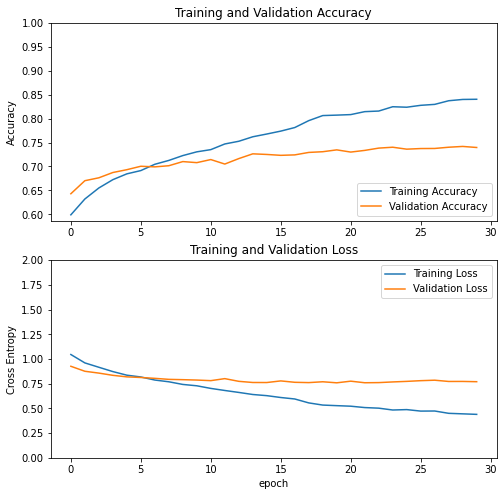

In [14]:
acc = history_unfreeze.history['accuracy']
val_acc = history_unfreeze.history['val_accuracy']

loss = history_unfreeze.history['loss']
val_loss = history_unfreeze.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('InceptionV3 score.png')
plt.show()

model.save("InceptionV3.h5")

In [15]:
import pandas as pd
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history_unfreeze.history) 

# save to json:  
hist_json_file = 'InceptionV3_finetune_history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)
    
hist_csv_file = 'InceptionV3_finetune_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)